In [1]:
import os
import time
import copy
import numpy as np
from astropy import units
from astropy.coordinates import Angle, SkyCoord, EarthLocation, AltAz
from astropy.time import Time

from pyuvdata import UVData

from bda import bda_tools, decorr_calc
import importlib
# importlib.reload(bda_tools)

import importlib.util
spec = importlib.util.spec_from_file_location("spec_calcs", "/Users/bryna/Projects/Physics/HERA/ProjectFiles/spec_calcs/spec_calcs.py")

spec_calcs = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spec_calcs)

import matplotlib.pyplot as plt

In [2]:
def get_times_use(file_in, fraction_of_times):
    uv = UVData()
    uv.read(file_in, read_data=False)
    unique_times = np.unique(uv.time_array)
    n_times = unique_times.size
    
    return unique_times[:int(round(n_times *fraction_of_times))]


In [3]:
def apply_bda(file_in, file_out, pre_fs_int_time=0.1, corr_FoV_angle=20.0,
              max_time=30, corr_int_time=None, max_decorr=0.1, overwrite=False, filetype='uvh5',
              times_use=None):

    if os.path.exists(file_out) and overwrite is False:
        raise ValueError("{} exists. Use --overwrite to overwrite the file.".format(file_out))

    # check that output filetype is valid
    if filetype not in ("uvh5", "uvfits", "miriad"):
        raise ValueError("filetype must be one of uvh5, uvfits, or miriad")

    uv = UVData()
    uv.read(file_in, times=times_use, run_check_acceptability=False)

    # apply BDA
    pre_fs_int_time = pre_fs_int_time * units.s
    corr_FoV_angle = Angle(corr_FoV_angle, units.deg)
    max_time = max_time * units.s
    uv2 = bda_tools.apply_bda(
        uv,
        max_decorr,
        pre_fs_int_time,
        corr_FoV_angle,
        max_time,
        corr_int_time,
    )

    # write out file
    if filetype == "uvh5":
        uv2.write_uvh5(file_out, clobber=True)
    if filetype == "uvfits":
        uv2.write_uvfits(file_out, spoof_nonessential=True, force_phase=True)
    if filetype == "miriad":
        uv2.write_miriad(file_out, clobber=True)


In [4]:
uvfits_file_in = '/Volumes/Data1/pyuvsim_ref_sim/simulation_results/ref_1.2_uniform.uvfits'
uvh5_file_in = '/Volumes/Data1/pyuvsim_ref_sim/simulation_results/ref_1.2_uniform.uvh5'
uvh5_file_in_fixed = '/Volumes/Data1/pyuvsim_ref_sim/simulation_results/ref_1.2_uniform_fixed.uvh5'
if not os.path.isfile(uvh5_file_in_fixed):
    t0 = time.time()
    uv_in = UVData()
    print_str = 'time to read in '
    if not os.path.isfile(uvh5_file_in):
        uv_in.read(uvfits_file_in)
        print_str += 'uvfits file '
    else:
        uv_in.read(uvh5_file_in, run_check_acceptability=False)
        print_str += 'uvh5 file '
        
    if min(uv_in.integration_time) < 0.9:
        # simulation files were originally written with int time in days not seconds
        uv_in.integration_time = uv_in.integration_time * 3600 * 24
        uv_in.set_lsts_from_time_array()

    if uv_in.phase_type == 'phased':
        uv_in.unphase_to_drift(use_ant_pos=True)
        
    uv_in.write_uvh5(uvh5_file_in_fixed)
    t1 = time.time()
    
    print_str += 'and fix it: {t} seconds'.format(t=t1-t0)
    print(print_str)

In [5]:
fraction_times_use = 0.1
short_file = '/Volumes/Data1/pyuvsim_ref_sim/simulation_results/ref_1.2_uniform_fixed_' + str(fraction_times_use) + '.uvh5'
if not os.path.isfile(short_file):
    times_use = get_times_use(file_in, fraction_times_use)
    uv_in = UVData()
    uv_in.read(uvh5_file_in_fixed, times=times_use, run_check_acceptability=False)
    uv_in.write_uvh5(short_file)

In [6]:
# file_in=short_file
file_in=uvh5_file_in_fixed
file_in_basename, file_extension = os.path.splitext(os.path.basename(file_in))
file_out='/Volumes/Data1/bda_outputs/' + file_in_basename + '_bda.uvh5'
initial_int_time=1.0  # seconds

In [7]:
if not os.path.isfile(file_out):
    t0 = time.time()
    apply_bda(file_in, file_out, pre_fs_int_time=initial_int_time, corr_FoV_angle=20.0,
              max_time=30, corr_int_time=None, overwrite=False, filetype='uvh5')
    t1 = time.time()
    print('time to read file into a uvdata object and do bda: {t} seconds'.format(t=t1-t0))

In [8]:
uv_in = UVData()
uv_in.read(file_in, run_check_acceptability=False)
uv_bda = UVData()
uv_bda.read(file_out, run_check_acceptability=False)


Telescope BLLITE is not in known_telescopes.


In [9]:
# only keep cross visibilities: no bda done on autos
uv_in.select(ant_str='cross')
uv_bda.select(ant_str='cross')

In [10]:
print('Input data')
print('Ntimes: ', uv_in.Ntimes)
print('Nfreqs: ', uv_in.Nfreqs)
print('Nbls: ', uv_in.Nbls)
print('Nblts: ', uv_in.Nblts)
print('data_array shape: ', uv_in.data_array.shape)
print('phase_type: ', uv_in.phase_type)

Input data
Ntimes:  86400
Nfreqs:  1
Nbls:  6
Nblts:  518400
data_array shape:  (518400, 1, 1, 4)
phase_type:  drift


In [11]:
print('BDA data')
print('Ntimes: ', uv_bda.Ntimes)
print('Nfreqs: ', uv_bda.Nfreqs)
print('Nbls: ', uv_bda.Nbls)
print('Nblts: ', uv_bda.Nblts)
print('data_array shape: ', uv_bda.data_array.shape)
print('phase_type: ', uv_in.phase_type)

BDA data
Ntimes:  5400
Nfreqs:  1
Nbls:  6
Nblts:  32400
data_array shape:  (32400, 1, 1, 4)
phase_type:  drift


In [12]:
unique_bls = np.unique(uv_in.baseline_array)

In [13]:
for bl in unique_bls:
    wh_bl = np.where(uv_in.baseline_array == bl)
    print('baseline: ({a1}, {a2}) {b}'.format(a1=uv_in.ant_1_array[wh_bl[0][0]], a2=uv_in.ant_2_array[wh_bl[0][0]], b=bl))
    time_diffs = np.diff(np.sort(uv_in.time_array[wh_bl]))*24*60*60
    int_times = uv_in.integration_time[wh_bl]
    nsamples = uv_in.nsample_array[wh_bl]
    print('min/max int_times: {}, {}'.format(np.min(int_times), np.max(int_times)))
    print('min/max time_diffs: {}, {}'.format(np.min(time_diffs), np.max(time_diffs)))

baseline: (1, 0) 69633
min/max int_times: 0.9999945759773254, 0.9999945759773254
min/max time_diffs: 0.9990692138671875, 1.0042190551757812
baseline: (2, 0) 71681
min/max int_times: 0.9999945759773254, 0.9999945759773254
min/max time_diffs: 0.9990692138671875, 1.0042190551757812
baseline: (2, 1) 71682
min/max int_times: 0.9999945759773254, 0.9999945759773254
min/max time_diffs: 0.9990692138671875, 1.0042190551757812
baseline: (3, 0) 73729
min/max int_times: 0.9999945759773254, 0.9999945759773254
min/max time_diffs: 0.9990692138671875, 1.0042190551757812
baseline: (3, 1) 73730
min/max int_times: 0.9999945759773254, 0.9999945759773254
min/max time_diffs: 0.9990692138671875, 1.0042190551757812
baseline: (3, 2) 73731
min/max int_times: 0.9999945759773254, 0.9999945759773254
min/max time_diffs: 0.9990692138671875, 1.0042190551757812


In [14]:
for bl in unique_bls:
    wh_bl = np.where(uv_bda.baseline_array == bl)
    print('baseline: ({a1}, {a2}) {b}'.format(a1=uv_bda.ant_1_array[wh_bl[0][0]], a2=uv_bda.ant_2_array[wh_bl[0][0]], b=bl))
    time_diffs = np.diff(np.sort(uv_bda.time_array[wh_bl]))*24*60*60
    int_times = uv_bda.integration_time[wh_bl]
    nsamples = uv_bda.nsample_array[wh_bl]
    print('min/max int_times: {}, {}'.format(np.min(int_times), np.max(int_times)))
    print('min/max time_diffs: {}, {}'.format(np.min(time_diffs), np.max(time_diffs)))

baseline: (1, 0) 69633
min/max int_times: 15.999913215637207, 15.999913215637207
min/max time_diffs: 15.997982025146484, 16.00184440612793
baseline: (2, 0) 71681
min/max int_times: 15.999913215637207, 15.999913215637207
min/max time_diffs: 15.997982025146484, 16.00184440612793
baseline: (2, 1) 71682
min/max int_times: 15.999913215637207, 15.999913215637207
min/max time_diffs: 15.997982025146484, 16.00184440612793
baseline: (3, 0) 73729
min/max int_times: 15.999913215637207, 15.999913215637207
min/max time_diffs: 15.997982025146484, 16.00184440612793
baseline: (3, 1) 73730
min/max int_times: 15.999913215637207, 15.999913215637207
min/max time_diffs: 15.997982025146484, 16.00184440612793
baseline: (3, 2) 73731
min/max int_times: 15.999913215637207, 15.999913215637207
min/max time_diffs: 15.997982025146484, 16.00184440612793


In [15]:
# bin at half the min int time to see full detail
bin_width = 0.5

# calculate length from 0 to max int time + 1 bin
max_inttime = np.round(np.max(uv_bda.integration_time))
length = np.round((max_inttime + 1)/bin_width + 1)

# center bins so numerical fluctuations don't cause splits between bins
bin_edges = np.arange(length)*bin_width-bin_width/2

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
print('bin centers:')
print(bin_centers)



bin centers:
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5]


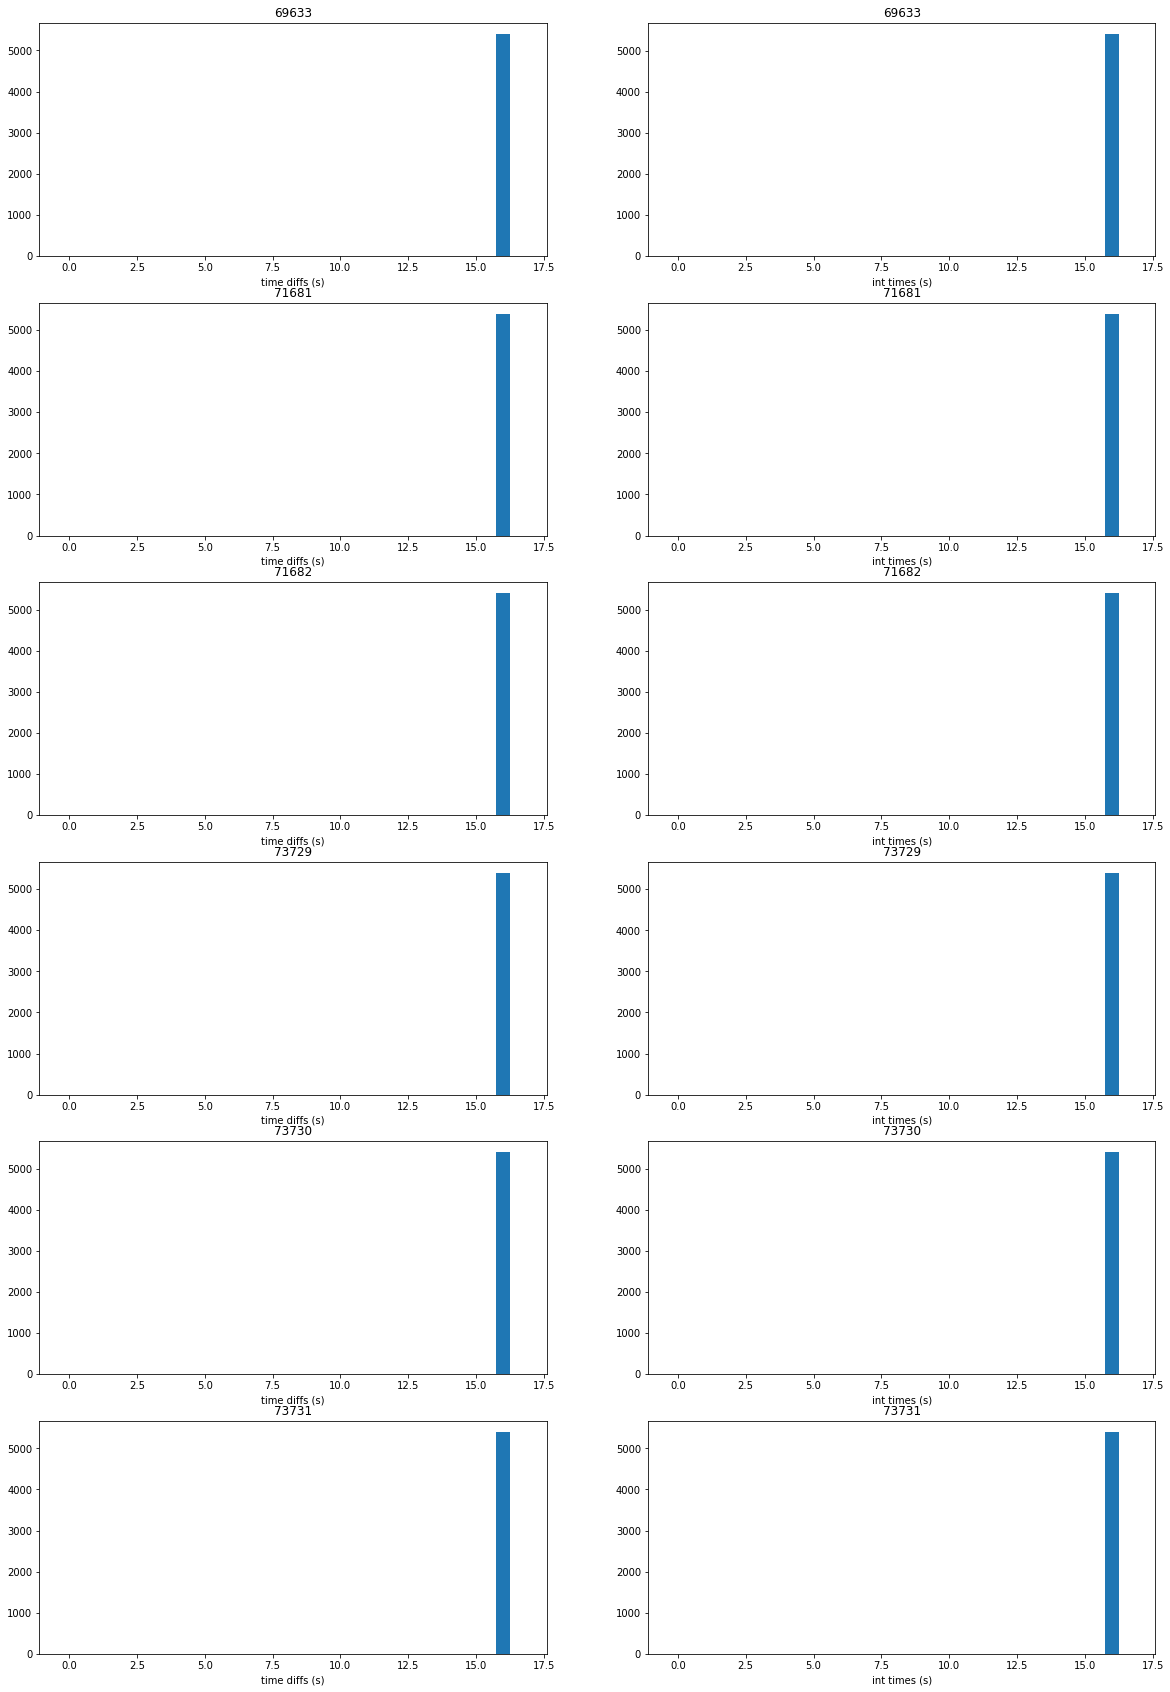

In [16]:
n_rows = unique_bls.size
plt.figure(figsize=(20,5*n_rows))
for index, bl in enumerate(unique_bls):
    time_diffs = np.diff(np.sort(uv_bda.time_array[np.where(uv_bda.baseline_array == bl)]))*24*60*60
    int_times = uv_bda.integration_time[np.where(uv_bda.baseline_array == bl)]
        
    plt.subplot(n_rows, 2, 2*index+1)
    plt.hist(time_diffs, bins=bin_edges)
    plt.title(bl)
    plt.xlabel('time diffs (s)')

    plt.subplot(n_rows, 2, 2*index+2)
    plt.hist(int_times, bins=bin_edges)
    plt.title(bl)
    plt.xlabel('int times (s)')
    

plt.show()

bin centers:
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]


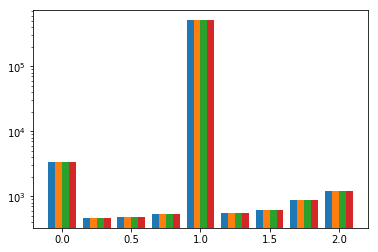

In [17]:
power_in_all = np.squeeze(np.abs(uv_in.data_array))

# bin at quarter Jy
bin_width = 0.25

# calculate length from 0 to max power + 1 bin
max_power_bin = np.round(np.max(power_in_all)/bin_width) + 1
length = max_power_bin + 1

# center bins so numerical fluctuations don't cause splits between bins
bin_edges = np.arange(length)*bin_width-bin_width/2

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
print('bin centers:')
print(bin_centers)

plt.hist(power_in_all, bin_edges, log=True)
plt.show()

bin centers:
[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75
 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75
 24.   24.25 24.5  24.75 25.   25.25 25.5  25.75 26.   26.25 26.5  26.75
 27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75
 30.   30.25 30.5  30.75 31.   31.25 31.5  31.75 32.  ]


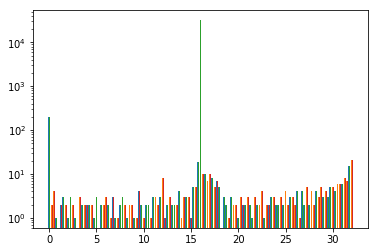

In [18]:
power_in_bda = np.squeeze(np.abs(uv_bda.data_array))

# bin at quarter Jy
bin_width = 0.25

# calculate length from 0 to max power + 1 bin
max_power_bin = np.round(np.max(power_in_bda)/bin_width) + 1
length = max_power_bin + 1

# center bins so numerical fluctuations don't cause splits between bins
bin_edges = np.arange(length)*bin_width-bin_width/2

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
print('bin centers:')
print(bin_centers)

plt.hist(power_in_bda, bin_edges, log=True)
plt.show()

In [19]:
# Now calculate decorrelation amount from simulated data
decorr_dict = {}
sim_times = {}
sim_lsts = {}
for bl in unique_bls:
    wh_bl_bda = np.where(uv_bda.baseline_array == bl)
    wh_bl_in = np.where(uv_in.baseline_array == bl)
    ant_pair = (uv_bda.ant_1_array[wh_bl_bda[0][0]], uv_bda.ant_2_array[wh_bl_bda[0][0]])
    print('baseline: ({a1}, {a2}) {b}'.format(a1=ant_pair[0], a2=ant_pair[1], b=bl))
    int_times_bda = uv_bda.integration_time[wh_bl_bda]
    int_times_in = uv_in.integration_time[wh_bl_in]
    
    integration_factor = np.mean(int_times_bda) / np.mean(int_times_in)
    print('integration factor: ', integration_factor)
    integration_factor = int(np.round(integration_factor))
        
    power_in = np.abs(uv_in.get_data(ant_pair))
    times_in = uv_in.time_array[wh_bl_in]
    power_bda = np.abs(uv_bda.get_data(ant_pair))

    power_in_integrated = np.zeros_like(power_bda)
    times_in_integrated = np.zeros_like(int_times_bda)
    for ind in np.arange(power_bda.shape[0]):
        power_in_integrated[ind, :, :] = np.sum(power_in[ind*integration_factor:(ind+1)*integration_factor, :, :], axis=0)
        times_in_integrated[ind] = np.mean(times_in[ind*integration_factor:(ind+1)*integration_factor])
    
    power_diff = (power_in_integrated - power_bda)

    wh_zero_power = np.where(power_in_integrated == 0)
    denominator = copy.copy(power_in_integrated)
    denominator[wh_zero_power] = 1

    decorr = power_diff / denominator
    print('min/max decorr: {}, {}'.format(np.min(decorr), np.max(decorr)))
    
    decorr_dict[ant_pair] = {'integration_factor': integration_factor, 'frac_decorr': decorr}

    bda_times = uv_bda.time_array[wh_bl_bda]
    
    # check bda times equal mean times going into integration to 2 millisecond
    assert np.allclose(bda_times, times_in_integrated, atol=2e-3/(24*3600.), rtol=0)
    
    sim_times[ant_pair] = bda_times
    bda_lsts = uv_bda.lst_array[wh_bl_bda]
    sim_lsts[ant_pair] = bda_lsts

baseline: (1, 0) 69633
integration factor:  16.0
min/max decorr: -1.1920928955078125e-07, 0.11041060835123062
baseline: (2, 0) 71681
integration factor:  16.0
min/max decorr: -2.697380523386528e-07, 0.6370037198066711
baseline: (2, 1) 71682
integration factor:  16.0
min/max decorr: -1.1920928955078125e-07, 0.7341785430908203
baseline: (3, 0) 73729
integration factor:  16.0
min/max decorr: -1.1920928955078125e-07, 0.11935816705226898
baseline: (3, 1) 73730
integration factor:  16.0
min/max decorr: -1.1920928955078125e-07, 0.16765740513801575
baseline: (3, 2) 73731
integration factor:  16.0
min/max decorr: -1.1920928955078125e-07, 0.029241912066936493


In [20]:
src1 = {'ra': 108.05159, 'dec':-0.9894784}
src2 = {'ra': 291.49730, 'dec':-1.0600652}

telescope_location = EarthLocation.from_geocentric(*uv_bda.telescope_location, unit='m')

src1_skycoord = SkyCoord(Angle(src1['ra'], units.deg), Angle(src1['dec'], units.deg),
                         frame='icrs', location=telescope_location)
src2_skycoord = SkyCoord(Angle(src2['ra'], units.deg), Angle(src2['dec'], units.deg),
                         frame='icrs', location=telescope_location)

In [21]:
time_obj_array = Time(np.unique(uv_bda.time_array), format='jd', location=telescope_location)
time_obj_lst_array = time_obj_array.sidereal_time('apparent').degree

src1_altaz = src1_skycoord.transform_to(AltAz(obstime=time_obj_array))
src2_altaz = src2_skycoord.transform_to(AltAz(obstime=time_obj_array))


In [22]:
print(np.max(src1_altaz.alt))
print(np.max(src2_altaz.alt))
print(np.min(src1_altaz.alt))
print(np.min(src2_altaz.alt))

60d18m00.4851s
60d18m00.0203s
-58d15m24.4295s
-58d15m24.9979s


In [23]:
uv_2 = copy.deepcopy(uv_in)
uv_2.set_uvws_from_antenna_positions()

In [24]:
# calculated expected decorrelation
input_int_time = np.round(np.unique(uv_in.integration_time), decimals=4) * units.s

total_decorr_spec_calc = {}
total_decorr_bda = {}
calc_times = {}
calc_lsts = {}
fov_angle = {}
for bl in unique_bls:
    wh_bl_in = np.where(uv_in.baseline_array == bl)
    ant_pair = (uv_in.ant_1_array[wh_bl_in[0][0]], uv_in.ant_2_array[wh_bl_in[0][0]])
    if ant_pair[0] == ant_pair[1]:
        continue
    print('baseline: ({a1}, {a2}) {b}'.format(a1=ant_pair[0], a2=ant_pair[1], b=bl))

    baseline_len_m = np.linalg.norm(uv_2.uvw_array[wh_bl_in[0], :], axis=1)
    baseline_len_m = np.unique(baseline_len_m)
    assert baseline_len_m.size == 1
    baseline_len_m = baseline_len_m[0]*units.m
    print('baseline length:', baseline_len_m)

    baseline_len_ew_m = np.abs(np.unique(uv_2.uvw_array[wh_bl_in[0], 0])[0])*units.m
    baseline_len_ns_m = np.abs(np.unique(uv_2.uvw_array[wh_bl_in[0], 1])[0])*units.m
    print('EW baseline length:', baseline_len_ew_m)
    print('NS baseline length:', baseline_len_ns_m)
    
    this_int_time = decorr_dict[ant_pair]['integration_factor']*input_int_time

    wh_bl_bda = np.where(uv_bda.baseline_array == bl)
    this_time_array = uv_bda.get_times(ant_pair)
    this_lst_array = uv_bda.lst_array[wh_bl_bda[0]]
    
    chan_width = (1 * units.kHz)
    freq = uv_bda.freq_array[0, 0]*units.Hz
 
    decorr_pre_int = decorr_calc.decorr_pre_fs_int_time(freq, baseline_len_m, input_int_time)

    total_decorr_spec_calc[ant_pair] = []
    total_decorr_bda[ant_pair] = []
    calc_times[ant_pair] = []
    calc_lsts[ant_pair] = []
    fov_angle[ant_pair] = []
    for ind, jd in enumerate(this_time_array):
        wh_jd = np.where(time_obj_array.jd == jd)
        assert wh_jd[0].size == 1
        calc_times[ant_pair].append(jd)
        calc_lsts[ant_pair].append(this_lst_array[ind])
        
        max_alt = max([src1_altaz[wh_jd].alt, src2_altaz[wh_jd].alt, Angle(0., units.degree)])
        corr_FoV_angle = Angle(90., units.degree) - max_alt
        assert corr_FoV_angle.degree >= 0, 'fov angle less than zero. Angle is: ' + str(corr_FoV_angle.degree)
        assert corr_FoV_angle.degree <= 90, 'fov angle greater than 90 degrees. Angle is: ' + str(corr_FoV_angle.degree)
        fov_angle[ant_pair].append(corr_FoV_angle.degree)
        
        decorrelations = spec_calcs.decorrelations(frequency=freq,
                                                   baseline=baseline_len_ew_m,
                                                   corr_FoV=corr_FoV_angle,
                                                   n_channels=1, chan_width=chan_width,
                                                   integration_time=this_int_time,
                                                   fringe_stop_int_time=input_int_time,
                                                   verbose=False)
        total_decorr_spec_calc[ant_pair].append(decorrelations['post_fs_total_decorr'])

        decorr_cw = decorr_calc.decorr_chan_width(chan_width, baseline_len_m, corr_FoV_angle)

        decorr_post_int, max_rfac = decorr_calc.decorr_post_fs_int_time(
            baseline_len_ew_m, baseline_len_ns_m, this_int_time, corr_FoV_angle, freq,
            telescope_latitude=telescope_location.lat)

        pre_fs_decorr = 1 - (1 - decorr_cw) * (1 - decorr_pre_int)
        total_decorr = 1 - (1 - pre_fs_decorr) * (1 - decorr_post_int)

        total_decorr_bda[ant_pair].append(total_decorr)

    total_decorr_spec_calc[ant_pair] = np.array(total_decorr_spec_calc[ant_pair])
    total_decorr_bda[ant_pair] = np.array(total_decorr_bda[ant_pair])
    calc_times[ant_pair] = np.array(calc_times[ant_pair])
    calc_lsts[ant_pair] = np.array(calc_lsts[ant_pair])
    fov_angle[ant_pair] = np.array(fov_angle[ant_pair])
    print('max total decorrelation (spec_calc): ', np.max(total_decorr_spec_calc[ant_pair]))
    print('max total decorrelation (bda): ', np.max(total_decorr_bda[ant_pair]))
    print('')

baseline: (1, 0) 69633
baseline length: 49.99999999997711 m
EW baseline length: 49.99999999997711 m
NS baseline length: 6.194161096357301e-11 m
max total decorrelation (spec_calc):  0.020219733810230345
max total decorrelation (bda):  0.0014938899700566166

baseline: (2, 0) 71681
baseline length: 50.000000000220126 m
EW baseline length: 9.750474882761607e-11 m
NS baseline length: 50.000000000220126 m


invalid value encountered in arcsin


max total decorrelation (spec_calc):  nan
max total decorrelation (bda):  0.002004048431960559

baseline: (2, 1) 71682
baseline length: 70.71067811868149 m
EW baseline length: 49.999999999879606 m
NS baseline length: 50.00000000015819 m
max total decorrelation (spec_calc):  0.020219733810191043
max total decorrelation (bda):  0.002843710675838884

baseline: (3, 0) 73729
baseline length: 36.76955262160344 m
EW baseline length: 25.999999999915197 m
NS baseline length: 25.999999999947573 m
max total decorrelation (spec_calc):  0.010501159790547665
max total decorrelation (bda):  0.0012526323837686038

baseline: (3, 1) 73730
baseline length: 35.38361202586622 m
EW baseline length: 24.000000000061917 m
NS baseline length: 25.99999999988563 m
max total decorrelation (spec_calc):  0.009689937280577765
max total decorrelation (bda):  0.001204703328089085

baseline: (3, 2) 73731
baseline length: 35.383612025959174 m
EW baseline length: 25.999999999817692 m
NS baseline length: 24.000000000272557

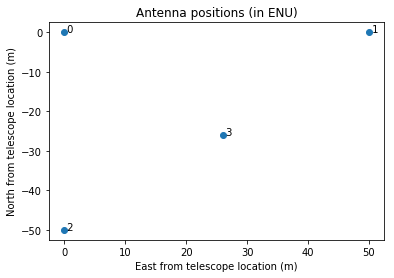

In [25]:
ant_enu_pos, ant_nums = uv_in.get_ENU_antpos()

plt.scatter(ant_enu_pos[:, 0], ant_enu_pos[:, 1])
plt.xlabel('East from telescope location (m)')
plt.ylabel('North from telescope location (m)')
plt.title('Antenna positions (in ENU)')

for i, num in enumerate(ant_nums):
    plt.annotate(' ' + str(num), (ant_enu_pos[i, 0], ant_enu_pos[i, 1]))


In [26]:
def decorr_plot(yrange=[-0.0001, 0.021], ylog=False, plot_decorr_zero=False):

    n_rows = unique_bls.size
    plt.figure(figsize=(20,5*n_rows))

    ax1_color = 'xkcd:dark rose'
    src1_color = 'xkcd:pinkish'
    src2_color = 'xkcd:dusty pink'
    
    ax2_color = 'xkcd:dusk blue'
    decorr_color = 'xkcd:windows blue'
    for index, bl in enumerate(unique_bls):
        wh_bl_bda = np.where(uv_bda.baseline_array == bl)
        ant_pair = (uv_bda.ant_1_array[wh_bl_bda[0][0]], uv_bda.ant_2_array[wh_bl_bda[0][0]])

        inds1, inds2, indp = uv_bda._key2inds(ant_pair)
        bl_lst_array = uv_bda.lst_array[inds1]
        # convert to degrees
        bl_lst_array = np.rad2deg(bl_lst_array)

        ax1 = plt.subplot(n_rows, 1, index+1)
        ax1.set_xlabel('LST (degrees)')
        ax1.set_ylabel('source altitude', color=ax1_color)
        sort_inds = np.argsort(time_obj_lst_array)
        ln1 = ax1.plot(time_obj_lst_array[sort_inds], src1_altaz[sort_inds].alt,
                       color=src1_color, label='src1')
        ln2 = ax1.plot(time_obj_lst_array[sort_inds], src2_altaz[sort_inds].alt,
                       color=src2_color, label='src2')
        ax1.tick_params(axis='y', labelcolor=ax1_color)
        ax1.axhline(color=ax1_color)

        ax2 = ax1.twinx()
        ax2.set_ylabel('Fractional decorrelation', color=ax2_color)
        ax2.tick_params(axis='y', labelcolor=ax2_color)
        if plot_decorr_zero:
            ax2.axhline(color=ax2_color)
        if not ylog:
            ax2.set_ylim(yrange[0], yrange[1])
        else:
            ax2.set_ylim(abs(yrange[0]), abs(yrange[1]))
            ax2.set_yscale('log')
        # sort by the lsts so we don't get weird lines
        lst_array = np.rad2deg(np.array(sim_lsts[ant_pair]))
        sort_inds = np.argsort(lst_array)
        ln3 = ax2.plot(lst_array[sort_inds], decorr_dict[ant_pair]['frac_decorr'][:, 0, 0][sort_inds],
                       label='sim', color=decorr_color)

        lst_array = np.rad2deg(np.array(calc_lsts[ant_pair]))
        sort_inds = np.argsort(lst_array)
        ln4 = ax2.plot(lst_array[sort_inds], total_decorr_bda[ant_pair][sort_inds], color=decorr_color,
                       linestyle='--', label='bda calc')
        ln5 = ax2.plot(lst_array[sort_inds], total_decorr_spec_calc[ant_pair][sort_inds], color=decorr_color,
                       linestyle=':', label='spec_calc calc')

        ln6 = ax1.plot(lst_array[sort_inds], fov_angle[ant_pair][sort_inds], color=ax1_color,
                   linestyle='--', label='fov angle')
        
#         lst_array = bl_lst_array
#         sort_inds = np.argsort(lst_array)
#         bda_power = np.abs(uv_bda.get_data(ant_pair)[:, 0, 0])
#         bda_power_frac_diff = (decorr_dict[ant_pair]['integration_factor'] - bda_power) / decorr_dict[ant_pair]['integration_factor']
#         ln7 = ax2.plot(lst_array[sort_inds], bda_power_frac_diff[sort_inds], color=decorr_color,
#                        linestyle='-.', label='sim apriori decorr')

        plt.title(str(ant_pair) + ' integration factor: ' + str(decorr_dict[ant_pair]['integration_factor']))

        lns = ln1 + ln2 + ln6 + ln3 + ln4 + ln5
        labs = [l.get_label() for l in lns]


        # Shrink current axis by 50%
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.5, box.height])

        # Put a legend to the right of the current axis
        ax2.legend(lns, labs, loc='center left', bbox_to_anchor=(1.1, 0.5))

    plt.show()

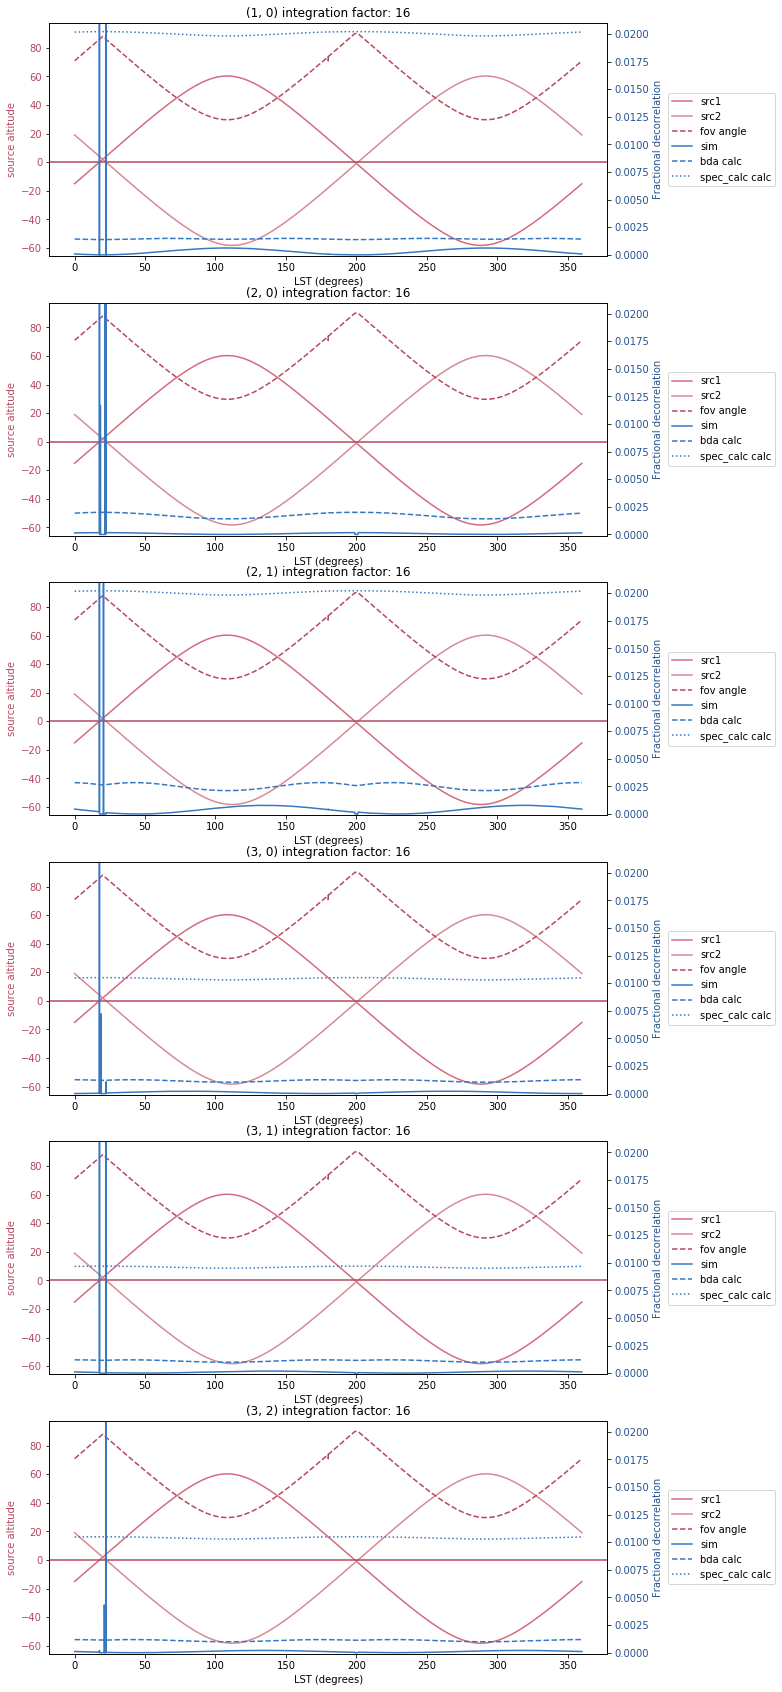

In [27]:
decorr_plot()

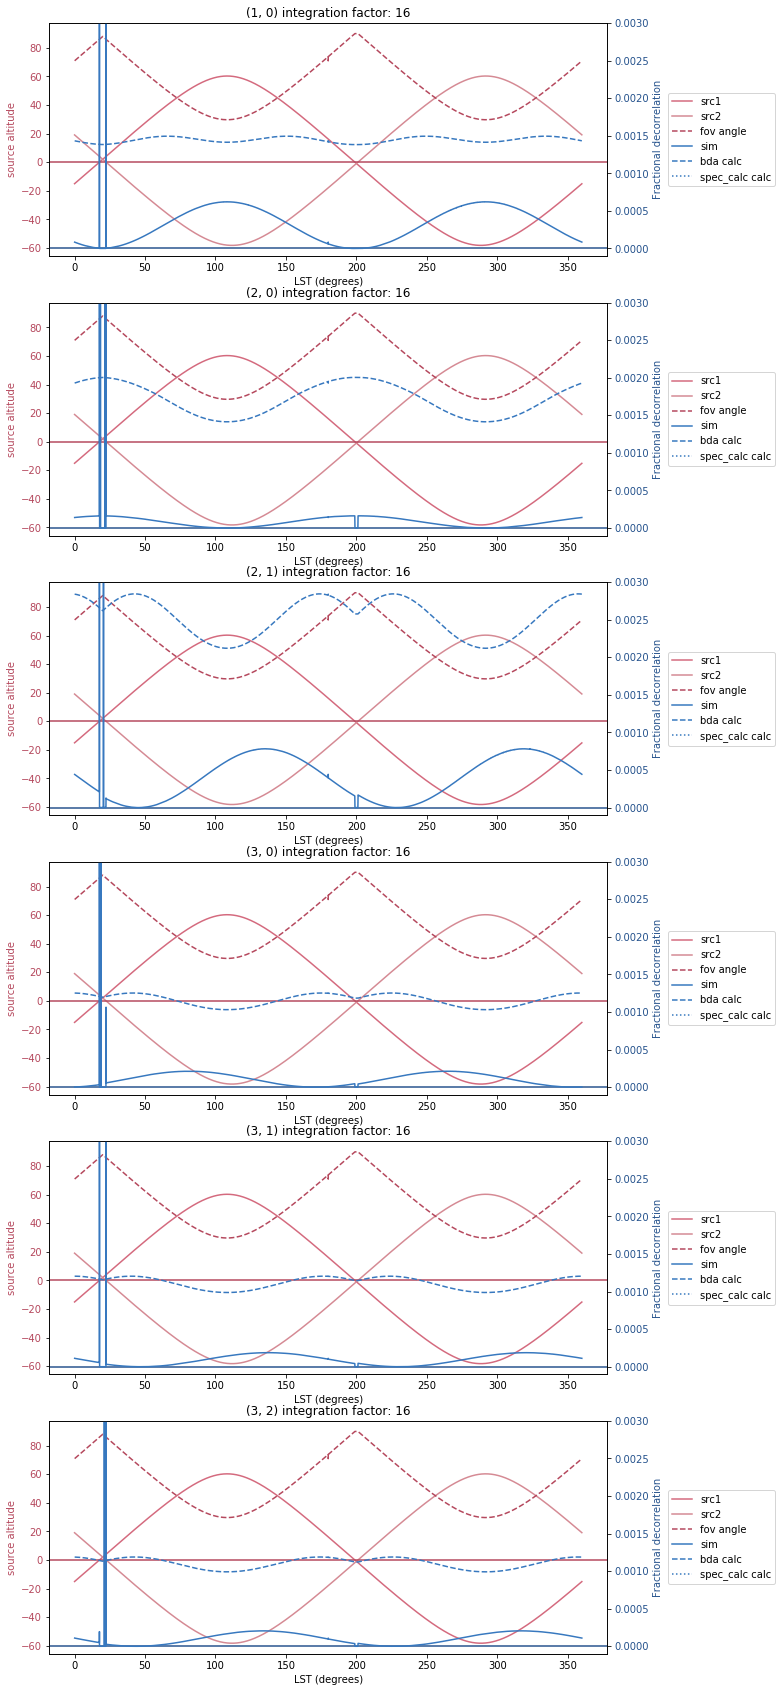

In [28]:
decorr_plot(yrange=[-0.0001, 0.003], plot_decorr_zero=True)